### DEMDP04 
# Job Search Model

Infinitely-lived worker must decide whether to quit, if employed, or search for a job, if unemployed, given prevailing market wages.

### States

-      w       prevailing wage
-     i       unemployed (0) or employed (1) at beginning of period

### Actions

-     j       idle (0) or active (i.e., work or search) (1) this period

### Parameters

| Parameter | Meaning    |
|-----------|-------------------------|
| $v$       | benefit of pure leisure |
| $\bar{w}$  | long-run mean wage |
| $\gamma$  | wage reversion rate |
| $p_0$      | probability of finding job |
| $p_1$      | probability of keeping job |
| $\sigma$   | standard deviation of wage shock |
| $\delta$   | discount factor |


# Preliminary tasks

In [1]:
%matplotlib inline
from warnings import simplefilter
simplefilter('ignore')
from compecon import BasisSpline, DPmodel
from compecon.quad import qnwnorm
from demos.setup import np, plt, demo

## FORMULATION
  
### Worker's reward

The worker's reward is:

- $w$ (the prevailing wage rate), if he's employed and active (working)
- $u=90$, if he's unemployed but active (searching)
- $v=95$, if he's idle (quit if employed, not searching if unemployed)

In [2]:
u     =  90
v     =  95

def reward(w, x, employed, active):
    if active:
        return w.copy() if employed else np.full_like(w, u)  # the copy is critical!!! otherwise it passes a pointer to w!!
    else:
        return np.full_like(w, v)

### Model dynamics

#### Stochastic Discrete State Transition Probabilities

An unemployed worker who is searching for a job has a probability $p_0=0.2$ of finding it, while an employed worker who doesn't want to quit his job has a probability $p_1 = 0.9$ of keeping it. An idle worker (someone who quits or doesn't search for a job) will definitely be unemployed next period. Thus, the transition probabilities are
\begin{align}
    q = \begin{bmatrix}1-p_0 &p_0\\1-p_1&p_1\end{bmatrix},&\qquad\text{if active} \\
      = \begin{bmatrix}1 & 0\\1 &0 \end{bmatrix},&\qquad\text{if iddle}
\end{align}

In [3]:
p0    = 0.20
p1    = 0.90

q = np.zeros((2, 2, 2))
q[1, 0, 1] = p0
q[1, 1, 1] = p1
q[:, :, 0] = 1 - q[:, :, 1]

#### Stochastic Continuous State Transition
Assuming that the wage rate $w$ follows an exogenous Markov process 
\begin{equation}
    w_{t+1} = \bar{w} + \gamma(w_t − \bar{w}) + \epsilon_{t+1}
\end{equation}

where $\bar{w}=100$ and $\gamma=0.4$. 

In [4]:
wbar  = 100
gamma = 0.40
def transition(w, x, i, j, in_, e):
    return wbar + gamma * (w - wbar) + e

Here, $\epsilon$ is normal $(0,\sigma^2)$ wage shock, where $\sigma=5$. We discretize this distribution with the function ```qnwnorm```.

In [5]:
sigma = 5
m = 15
e, w = qnwnorm(m, 0, sigma ** 2)

### Approximation Structure

To discretize the continuous state variable, we use a cubic spline basis with $n=150$ nodes between $w_\min=0$ and $w_\max=200$.

In [6]:
n = 150
wmin = 0
wmax = 200
basis = BasisSpline(n, wmin, wmax, labels=['wage'])

## SOLUTION

To represent the model, we create an instance of ```DPmodel```. Here, we assume a discout factor of $\delta=0.95$.

In [7]:
model = DPmodel(basis, reward, transition,
                i =['unemployed', 'employed'],
                j = ['idle', 'active'],
                discount=0.95, e=e, w=w, q=q)

Then, we call the method ```solve``` to solve the Bellman equation

In [8]:
S = model.solve(print=True)

Solving infinite-horizon model collocation equation by Newton's method
iter change       time    
------------------------------
   0       2.1e+03    0.2042
   1       3.5e+01    0.4630
   2       1.9e+01    0.7387
   3       1.4e+00    1.0000
   4       3.3e-12    1.2607
Elapsed Time =    1.26 Seconds


### Compute and Print Critical Action Wages

In [9]:
ni, nj = model.dims['ni', 'nj']
vr = S['value_j'].reshape(ni, nj, -1)
sr = S['wage'].reshape(ni, nj, -1)[0, 0]


wcrit0 = np.interp(0, vr[0, 1] - vr[0, 0], sr)
vcrit0 = np.interp(wcrit0, sr, vr[0,0])
print('Critical Search Wage = {:5.1f}'.format(wcrit0))

wcrit1 = np.interp(0, vr[1, 1] - vr[1, 0], sr)
vcrit1 = np.interp(wcrit1, sr, vr[1,0])
print('Critical Quit Wage   = {:5.1f}'.format(wcrit1))

Critical Search Wage =  93.8
Critical Quit Wage   =  79.4


### Plot Action-Contingent Value Function - Unemployed

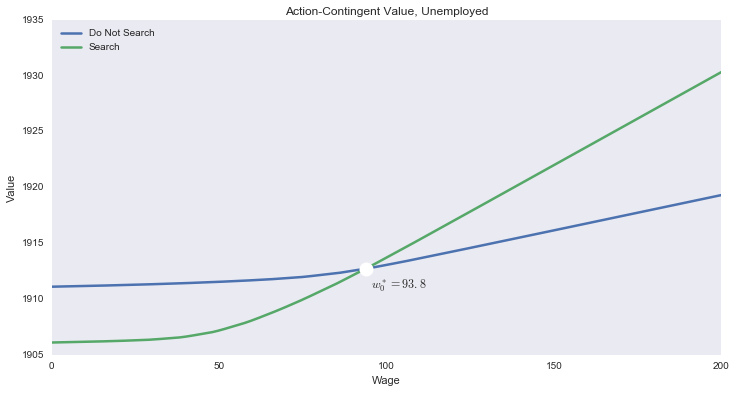

In [10]:
demo.figure('Action-Contingent Value, Unemployed', 'Wage', 'Value')
plt.plot(sr, vr[0].T)
demo.annotate(wcrit0, vcrit0, '$w^*_0 = {:.1f}$'.format(wcrit0), 'wo', (5, -5), fs=12)
plt.legend(['Do Not Search', 'Search'], loc='upper left')

### Plot Action-Contingent Value Function - Unemployed

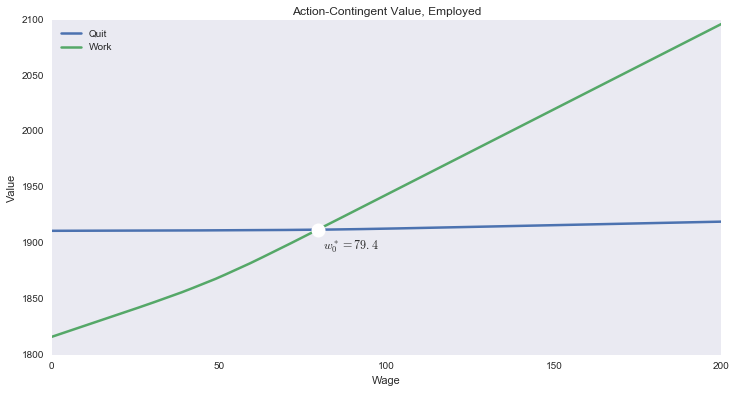

In [11]:
demo.figure('Action-Contingent Value, Employed', 'Wage', 'Value')
plt.plot(sr, vr[1].T)
demo.annotate(wcrit1, vcrit1, '$w^*_0 = {:.1f}$'.format(wcrit1), 'wo',
              (5, -5), fs=12)
plt.legend(['Quit', 'Work'], loc='upper left')

### Plot Residual

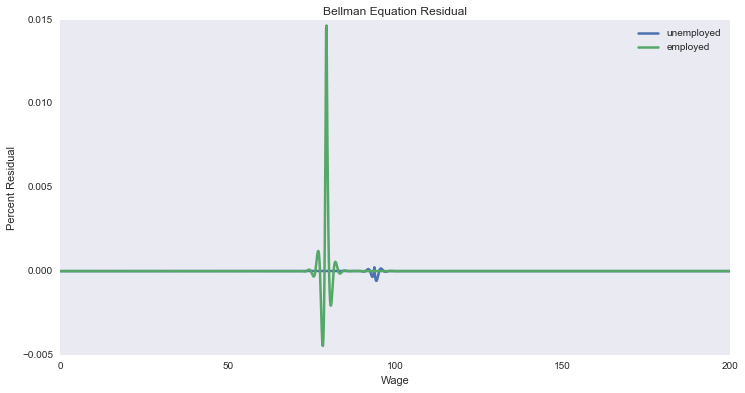

In [12]:
S['resid2'] = 100 * (S.resid / S.value)
resid = S['resid2'].reshape(ni, nj, -1)[:,0].T
demo.figure('Bellman Equation Residual', 'Wage', 'Percent Residual')
plt.plot(sr,resid)
plt.legend(model.labels.i)

## SIMULATION

### Simulate Model

We simulate the model 10000 times for a time horizon $T=40$, starting with an unemployed worker ($i=0$) at the long-term wage rate mean $\bar{w}$. To be able to reproduce these results, we set the random seed at an arbitrary value of 945.

In [13]:
T = 40
nrep = 10000
sinit = np.full((1, nrep), wbar)
iinit = 0
data = model.simulate(T, sinit, iinit, seed=945)

### Print Ergodic Moments

In [14]:
ff = '\t{:12s} = {:5.2f}'

print('\nErgodic Means')
print(ff.format('Wage', data['wage'].mean()))
print(ff.format('Employment', (data['i'] == 'employed').mean()))
print('\nErgodic Standard Deviations')
print(ff.format('Wage',data['wage'].std()))
print(ff.format('Employment', (data['i'] == 'employed').std()))


Ergodic Means
	Wage         = 100.02
	Employment   =  0.58

Ergodic Standard Deviations
	Wage         =  5.37
	Employment   =  0.49


### Plot Expected Discrete State Path

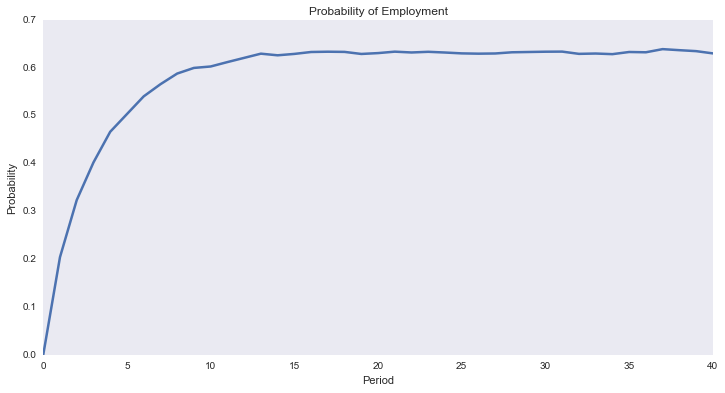

In [15]:
subdata = data[['time', 'i']]
subdata['i'] = subdata['i'] == 'employed'
subdata.groupby('time').mean().plot(legend=False)
plt.title('Probability of Employment')
plt.xlabel('Period')
plt.ylabel('Probability')

### Plot Simulated and Expected Continuous State Path

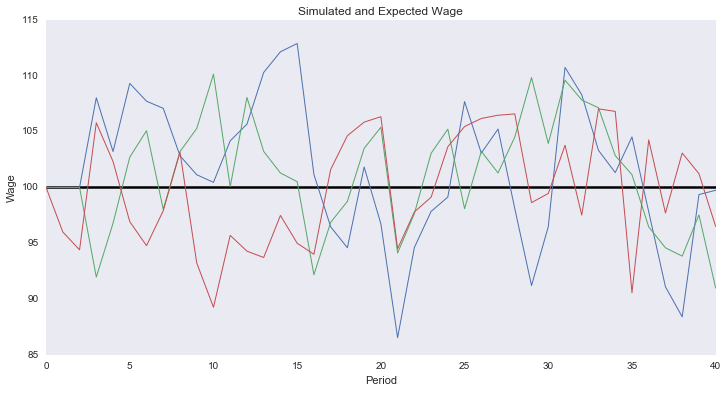

In [16]:
subdata = data[data['_rep'] < 3][['time', 'wage', '_rep']]
subdata.pivot(index='time', columns='_rep', values='wage').plot(legend=False, lw=1)
plt.hlines(data['wage'].mean(), 0, T)
plt.title('Simulated and Expected Wage')
plt.xlabel('Period')
plt.ylabel('Wage')